In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
merged = sc.read_h5ad("data/co_integrated_data/mouse_neurons+skinnider+knaf14.h5ad")

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\anndata\compat\__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
merged

AnnData object with n_obs × n_vars = 28221 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [5]:
np.unique(merged.obs['orig.ident'])

array(['BOUV5', 'GSE7474501', 'GSM7474503', 'KATHE', 'KNAF14', 'KNAF3',
       'KNAF4', 'MATSON'], dtype=object)

In [6]:
merged.obs['training_labels'].groupby(merged.obs['orig.ident']).value_counts()

orig.ident  training_labels
BOUV5       -1.0               1417
GSE7474501  -1.0               4260
GSM7474503  -1.0               6784
KATHE       -1.0               2331
KNAF14      -1.0               6039
KNAF3        0.0               3265
KNAF4        1.0               1820
MATSON      -1.0               2305
Name: count, dtype: int64

In [7]:
# merged.obs['orig.ident'] = merged.obs['orig.ident'].apply(lambda x: 'BOUV5' if x == 0 else 'KATHE' if x == 1 else 'KNAF3' if x == 2 else 'KNAF4' if x == 3 else 'MATSON' if x == 4 else 'TREVISAN')

In [8]:
# # Mark unnassigned to -1, and knaf3-4 that are not labeled 1 to 0
# merged.obs['labels'] = -1
# merged.obs.loc[merged.obs['orig.ident'] == 'KNAF3-4_En1Sun1NeuN-GFP', 'labels'] = 0
# merged.obs.loc[merged.obs['GFP'] > 0, 'labels'] = 1

In [9]:
merged.obs['training_labels'].value_counts()

training_labels
-1.0    23136
 0.0     3265
 1.0     1820
Name: count, dtype: int64

In [10]:
# check which space it uses to plot the umap 
merged

AnnData object with n_obs × n_vars = 28221 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_

In [11]:
merged.obs['training_labels'] = merged.obs['training_labels'].astype('category')

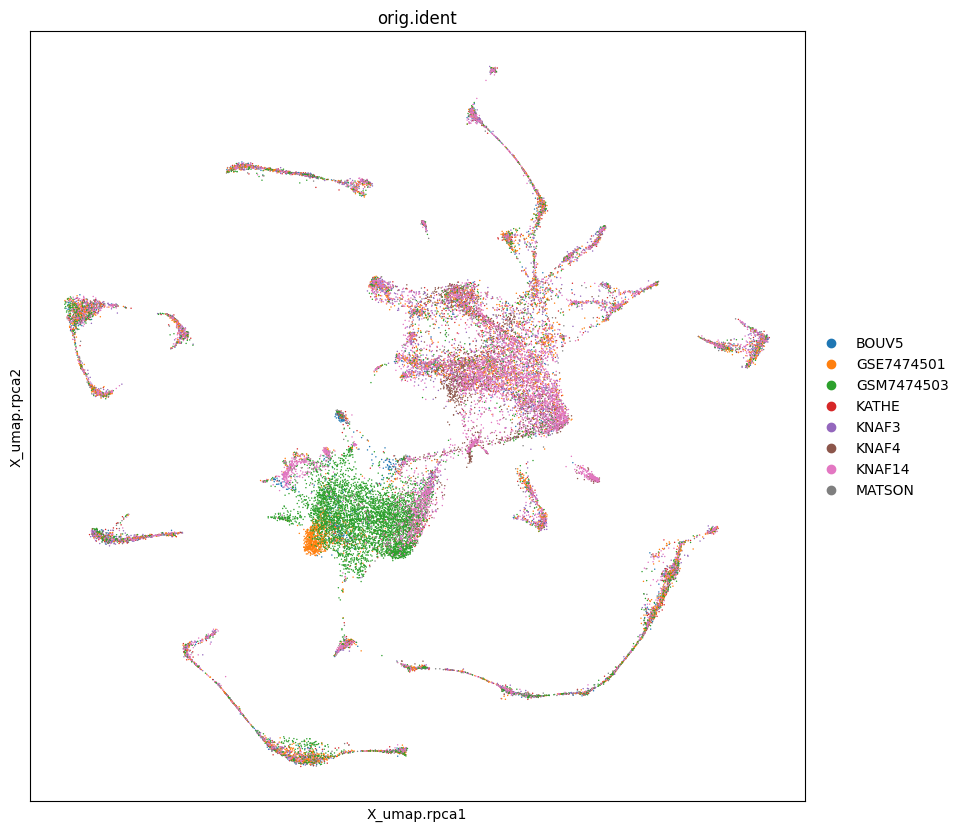

In [12]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, basis='X_umap.rpca', color='orig.ident', ax = ax)

In [13]:
merged.obs['annotation']  = merged.obs['training_labels'].apply(lambda x: 'CiteSeq+' if x == 1 else 'Citeseq-' if x == 0 else 'Unassigned')

In [14]:
merged.uns['annotation_colors'] = ['yellow', 'red', 'blue']

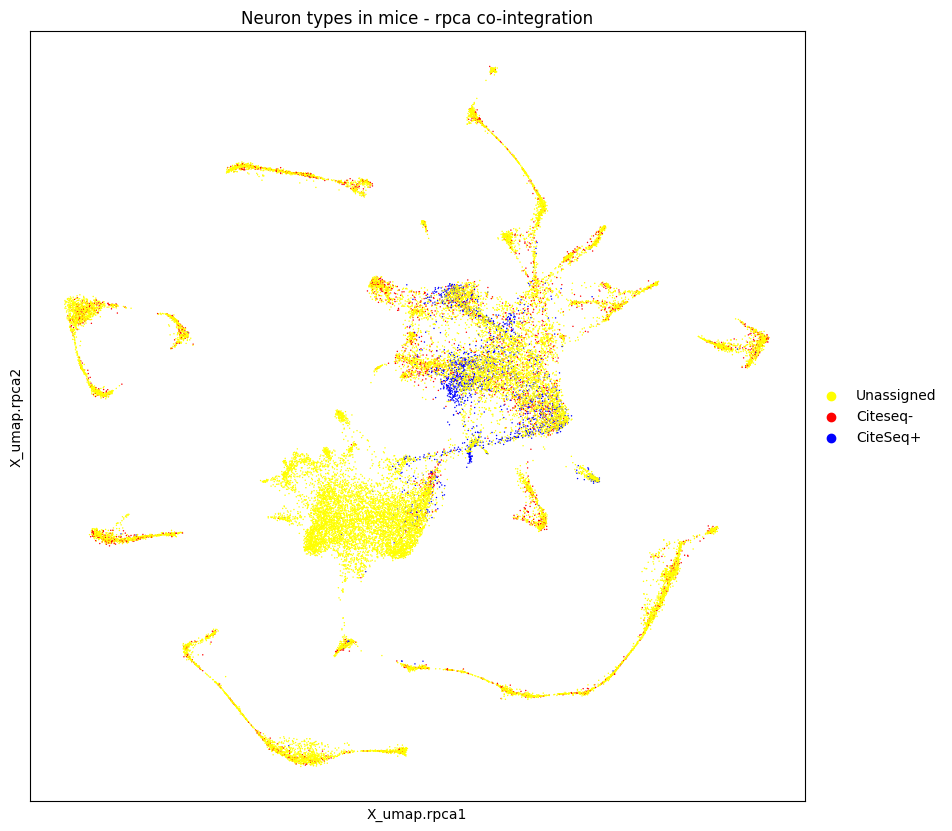

In [15]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, basis='X_umap.rpca', color='annotation', title='Neuron types in mice - rpca co-integration', ax = ax)

In [16]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation
BOUV5       Unassigned    1417
            Citeseq-         0
            CiteSeq+         0
GSE7474501  Unassigned    4260
            Citeseq-         0
            CiteSeq+         0
GSM7474503  Unassigned    6784
            Citeseq-         0
            CiteSeq+         0
KATHE       Unassigned    2331
            Citeseq-         0
            CiteSeq+         0
KNAF3       Citeseq-      3265
            Unassigned       0
            CiteSeq+         0
KNAF4       CiteSeq+      1820
            Unassigned       0
            Citeseq-         0
KNAF14      Unassigned    6039
            Citeseq-         0
            CiteSeq+         0
MATSON      Unassigned    2305
            Citeseq-         0
            CiteSeq+         0
Name: count, dtype: int64

## Outlier detection in the knaf3-4 neurons

In [537]:
# Outlier detection model
# Isolation Forest
from sklearn.ensemble import IsolationForest

# Extract knaf4 neurons
knaf4 = merged[merged.obs['training_labels'] == 1]

# Detect outliers
clf = IsolationForest(contamination=0.05)

# Train model
clf.fit(knaf4.X)

# Predict outliers
outliers = clf.predict(knaf4.X)

In [538]:
# Count outliers
unique, counts = np.unique(outliers, return_counts=True)

print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(91), np.int64(1): np.int64(1729)}


C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\2320479696.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  knaf4.obs['outliers'] = outliers


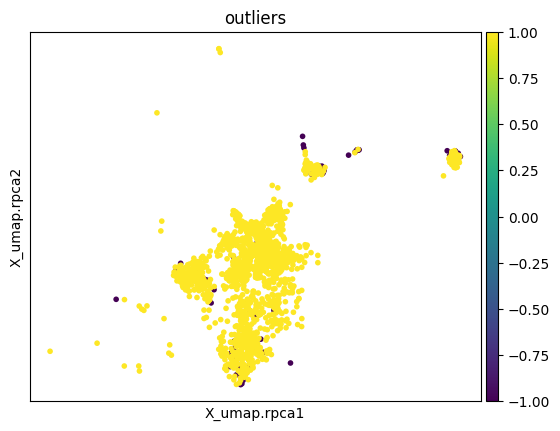

In [297]:
# Plot outliers in UMAP
knaf4.obs['outliers'] = outliers

sc.pl.embedding(knaf4, basis='X_umap.rpca', color='outliers')

No outliers

# Train classification model

## Use the original co-integration

In [18]:
# Split data into train, test and query
ref = merged[merged.obs['training_labels'] != -1]

In [19]:
ref.obs['training_labels'].value_counts()

training_labels
0.0    3265
1.0    1820
Name: count, dtype: int64

In [20]:
ref.uns['annotation_colors'] = ['yellow', 'blue']

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\620320016.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ref.uns['annotation_colors'] = ['yellow', 'blue']


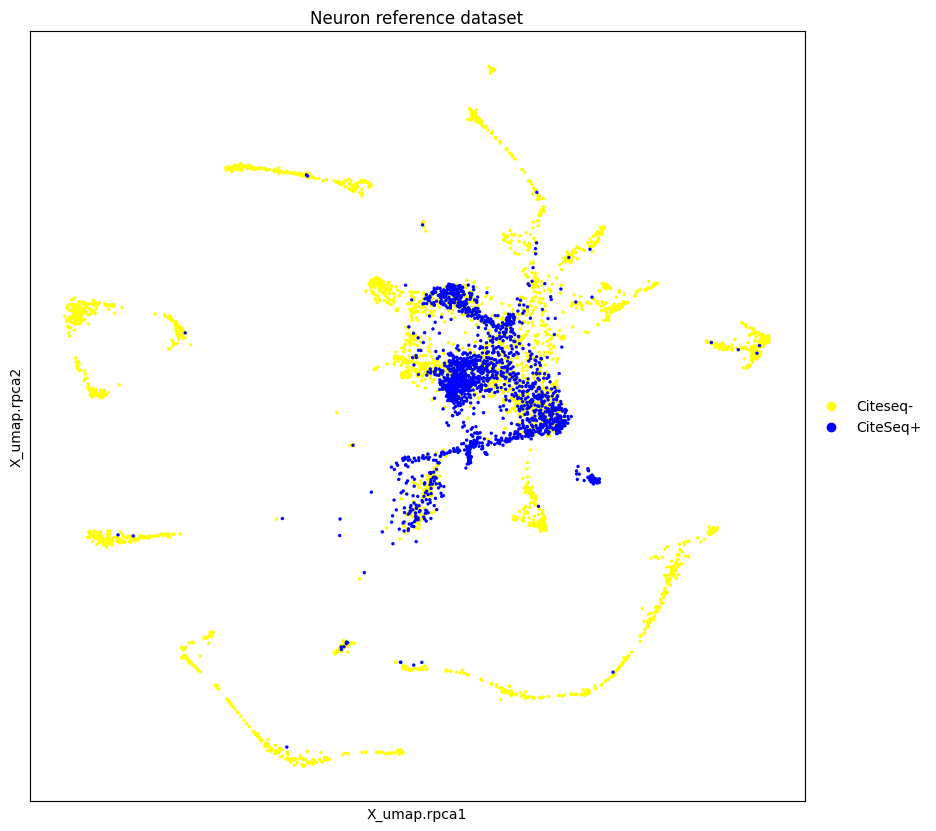

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(ref, basis='X_umap.rpca', color='annotation', title='Neuron reference dataset', ax = ax)

In [22]:
X = np.array(ref.X)
y = ref.obs['training_labels']
n_classes = len(np.unique(y))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [24]:
print("ref data shape: ", X.shape)
print("train data shape: ", X_train.shape)
print("test data shape: ", X_test.shape)
print("number of classes: ", n_classes)

ref data shape:  (5085, 2000)
train data shape:  (4068, 2000)
test data shape:  (1017, 2000)
number of classes:  2


In [ ]:
# Train xgboost
xgb = XGBClassifier()

In [ ]:
# Perform Grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\Emile\AppData\Local\Programs\Python\Py

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [24]:
xgb = grid_search.best_estimator_

In [25]:
# save best xgb model
xgb.save_model('models/mouse_annotation_xgb.json')

In [29]:
xgb.load_model('models/mouse_annotation_xgb.json')

In [36]:
# Predict using the best model
# xgb = grid_search.best_estimator_
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_xgb)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 97.25%
F1: 97.26%


In [30]:
cross_val_score(xgb, X, y)

array([0.97050147, 0.96951819, 0.96558505, 0.97246804, 0.97443461])

In [29]:
# Train a SVM model
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)

# Predict
y_pred_svm = svm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_svm, average='weighted')
print("F1: %.2f" % f1)

Accuracy: 96.85%
F1: 0.97


In [37]:
# Predict on query data
X_query = np.array(merged.X)
y_query_xgb = xgb.predict(X_query)
# y_query_svm = svm.predict(X_query)

merged.obs['labels_xgb'] = y_query_xgb
# merged.obs['labels_svm'] = y_query_svm

merged.obs['labels_xgb'] = merged.obs['labels_xgb'].astype('category')
# merged.obs['labels_svm'] = merged.obs['labels_svm'].astype('category')

In [38]:
merged.obs['labels_xgb'].value_counts()

labels_xgb
0    24038
1     4183
Name: count, dtype: int64

In [39]:
merged.obs['labels_svm'].value_counts()

KeyError: 'labels_svm'

In [40]:
# COmpare predictions

print(accuracy_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))
print(f1_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))

KeyError: 'labels_svm'

In [41]:
# Vount per orig
merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\549861126.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_xgb
BOUV5       0             1406
            1               11
GSE7474501  0             3999
            1              261
GSM7474503  0             6667
            1              117
KATHE       0             2275
            1               56
KNAF3       0             3243
            1               22
KNAF4       1             1814
            0                6
KNAF14      0             4185
            1             1854
MATSON      0             2257
            1               48
Name: count, dtype: int64

In [33]:
# Vount per orig
merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_15412\568467259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_svm
BOUV5       0.0           1415
            1.0              2
GSE7474501  0.0           4119
            1.0            141
GSM7474503  0.0           6731
            1.0             53
KATHE       0.0           2292
            1.0             39
KNAF3       0.0           3237
            1.0             28
KNAF4       1.0           1806
            0.0             14
MATSON      0.0           2275
            1.0             30
Name: count, dtype: int64

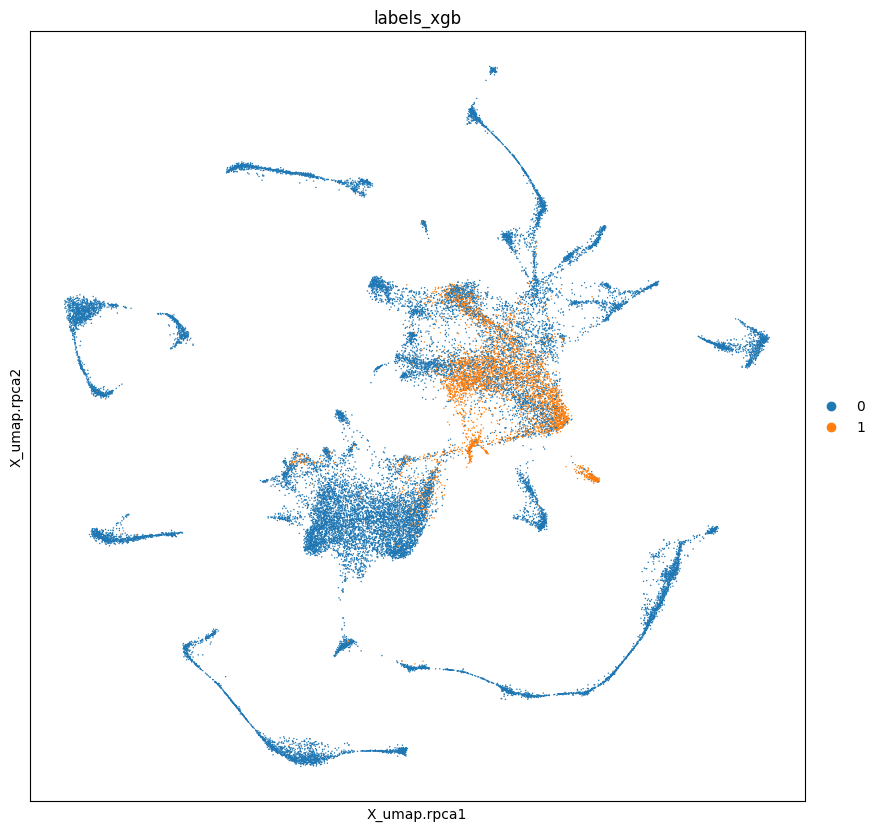

In [43]:
# Compare the results for each model
fig, ax = plt.subplots(1,1, figsize = (10,10))
# Plot umap with annotations using 4 colors for each annotation
# Change size of plot
sc.pl.embedding(merged, color='labels_xgb', basis='X_umap.rpca', ax = ax)

# fig, ax = plt.subplots(1,1, figsize = (10,10))
# sc.pl.embedding(merged, color='labels_svm', basis='X_umap.rpca',ax=ax)

In [44]:
annotation = []
v1 = []

for l, r in zip(merged.obs['labels_xgb'], merged.obs['training_labels']):
    if l == 1 and r == 1:
        annotation.append('V1_CITEseq+')
        v1.append('V1')
    elif l == 1 and r == 0:
        annotation.append('V1_predicted')
        v1.append('V1')
    elif l == 1 and r == -1:
        annotation.append('V1_predicted')
        v1.append('V1')
    elif l == 0 and r == -1:
        annotation.append('Not_V1_predicted')
        v1.append('Not_V1')
    elif l == 0 and r == 0:
        annotation.append('CITEseq-')
        v1.append('Not_V1')
    elif l == 0 and r == 1:
        annotation.append('Not_V1_predicted')
        v1.append('Not_V1')


In [45]:
pd.DataFrame(annotation).value_counts()

0               
Not_V1_predicted    20795
CITEseq-             3243
V1_predicted         2369
V1_CITEseq+          1814
Name: count, dtype: int64

In [1]:
16580+3239+550+1813

22182

In [49]:
merged.obs['annotation'] = annotation
merged.obs['v1'] = v1

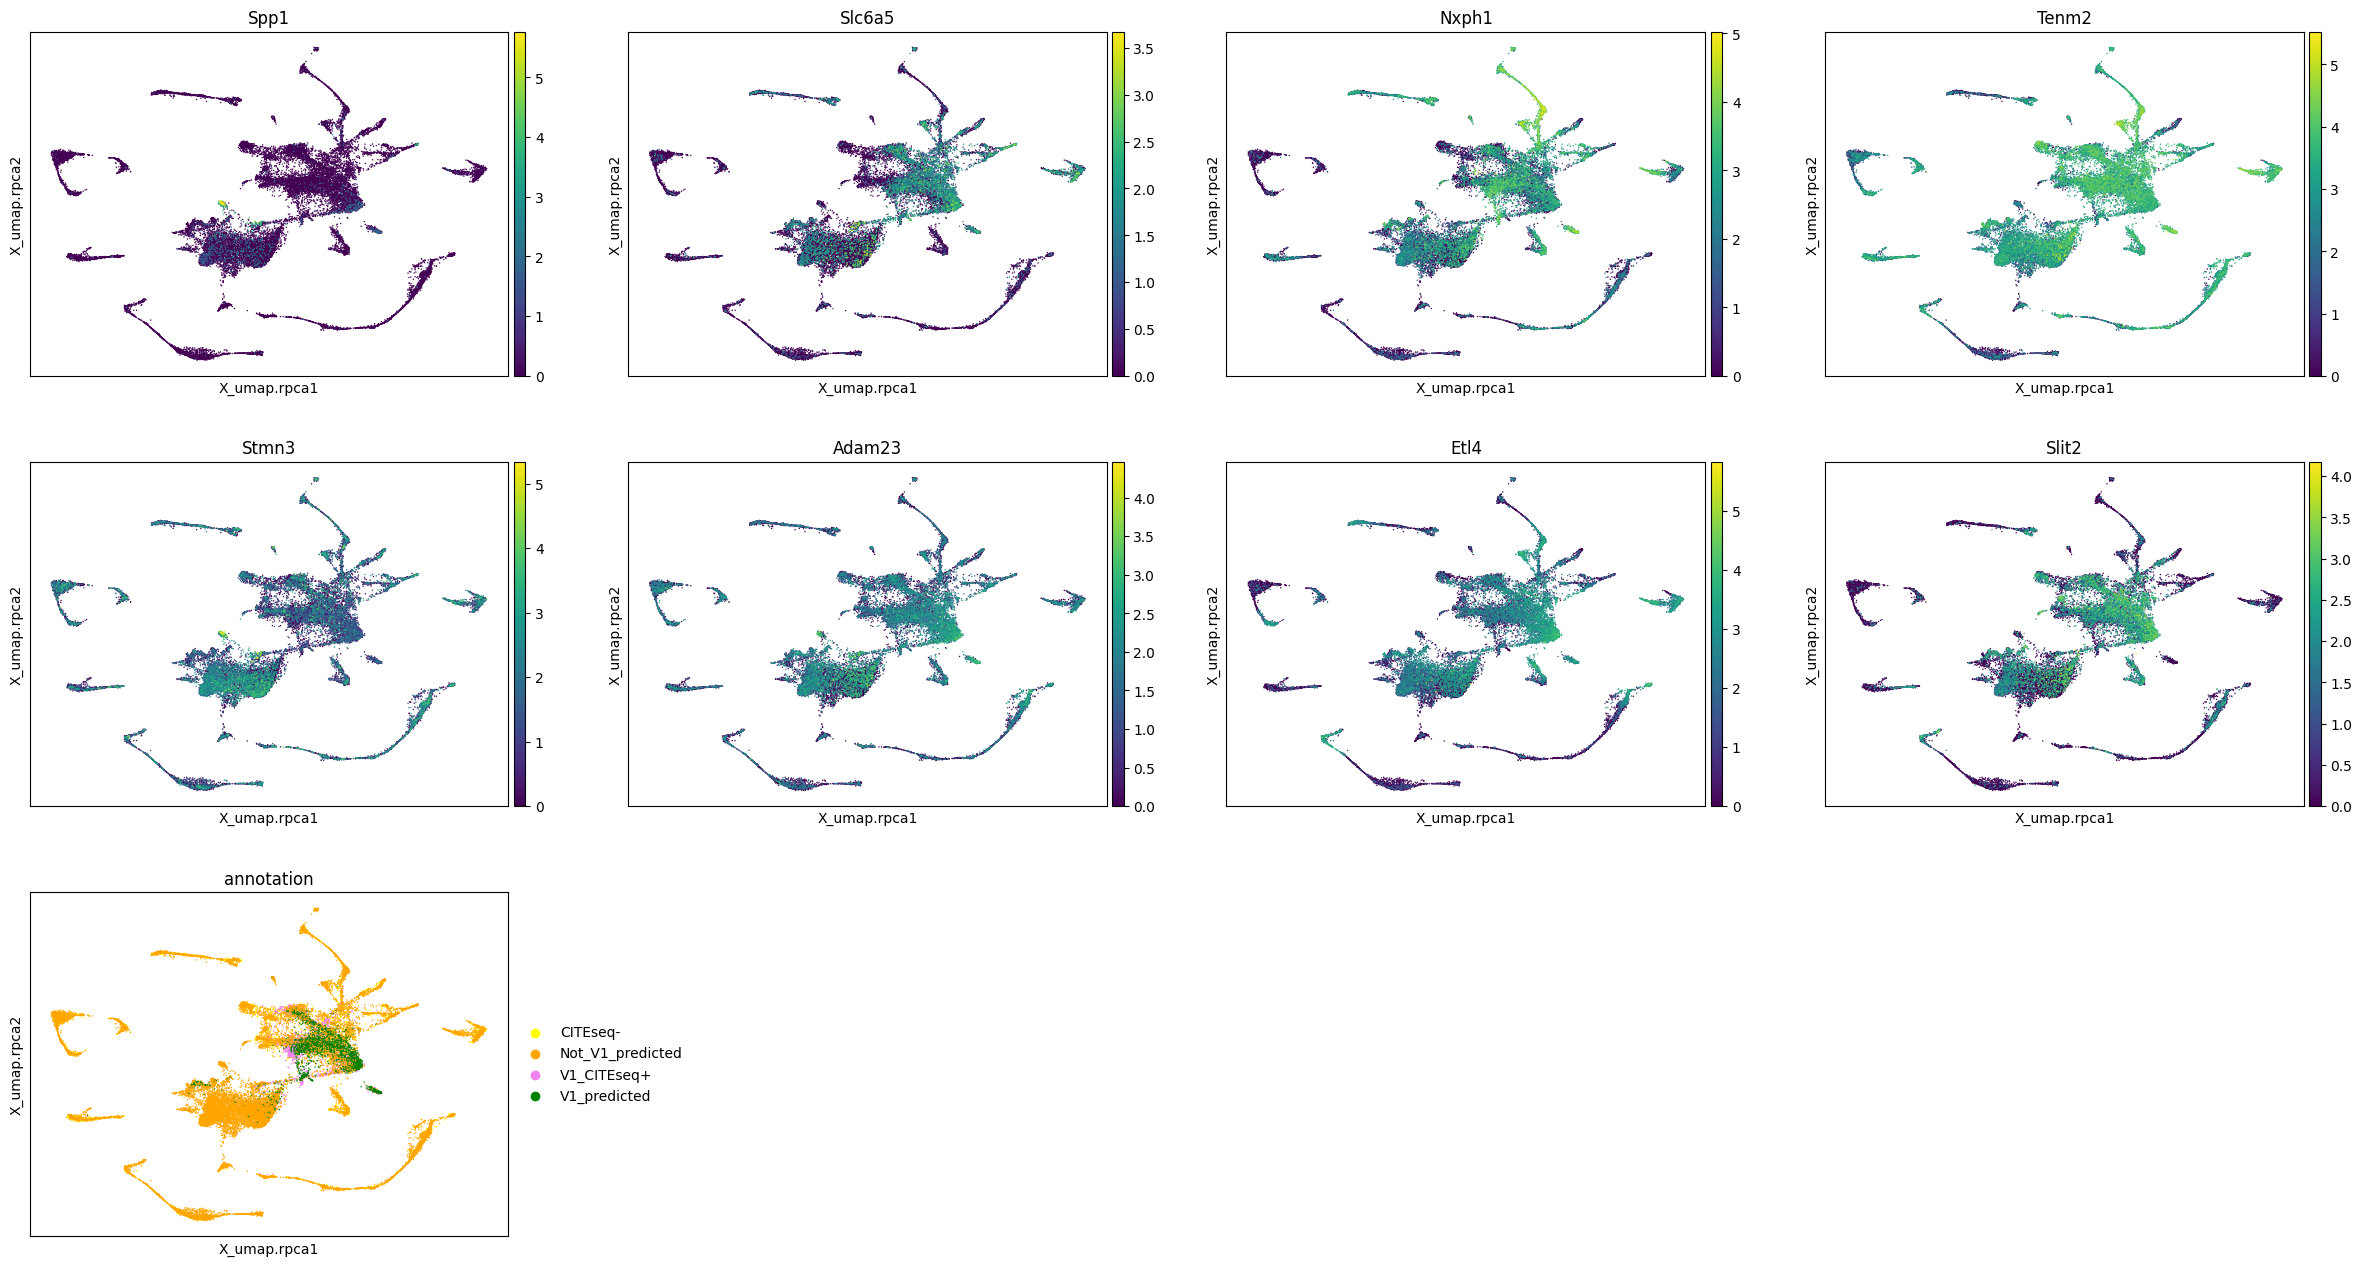

In [50]:
sc.pl.embedding(merged, color = ['Spp1', 'Slc6a5', 'Nxph1', 'Tenm2', 'Stmn3', 'Adam23', 'Etl4', 'Slit2', 'annotation'], basis='X_umap.rpca')

In [51]:
merged.uns['annotation_colors'] = ['yellow', 'orange', 'violet', 'green']

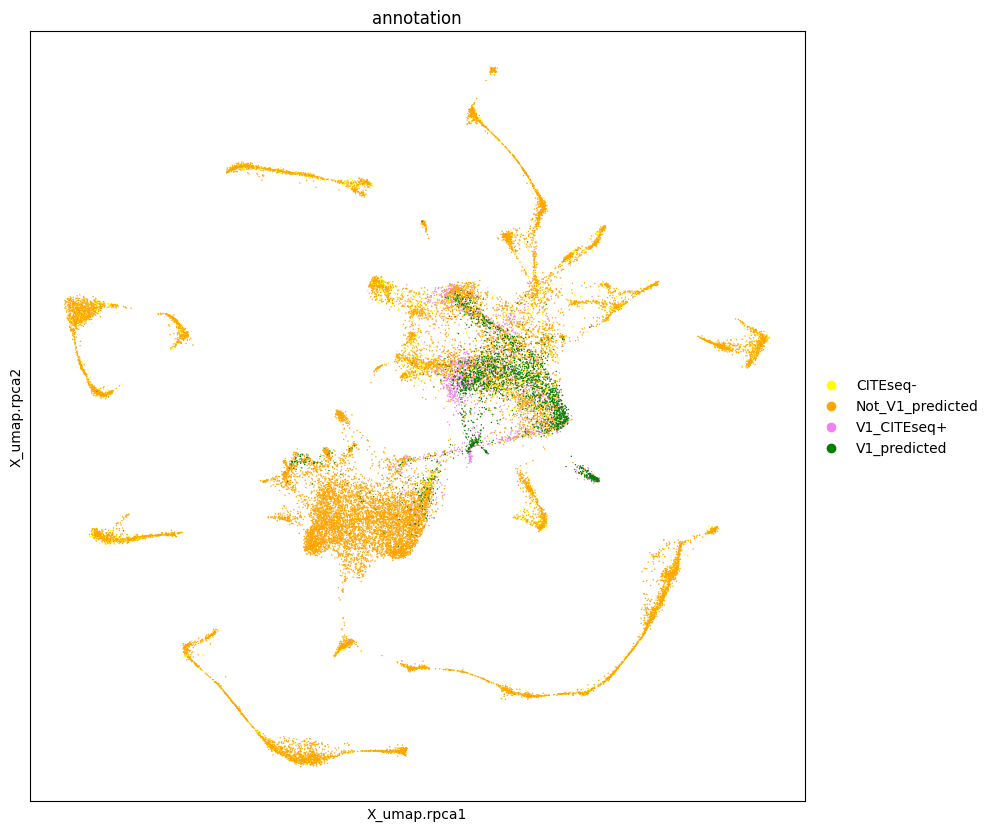

In [52]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, color='annotation', basis='X_umap.rpca', ax = ax)

In [53]:
merged.uns['v1_colors'] = ['yellow', 'blue']

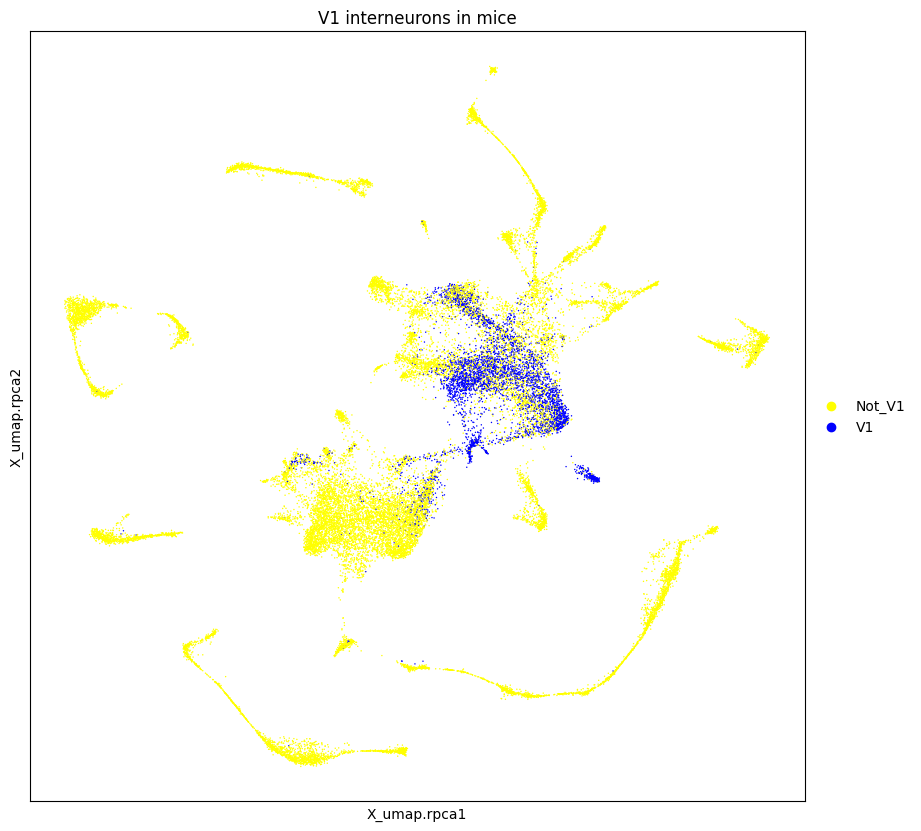

In [54]:
# Compare the results for each model
fig, ax = plt.subplots(1,1, figsize = (10,10))
# Plot umap with annotations using 4 colors for each annotation
# Change size of plot
sc.pl.embedding(merged, color='v1', basis='X_umap.rpca', ax = ax, title= 'V1 interneurons in mice')

In [55]:
merged.obs['v1'].value_counts()

v1
Not_V1    24038
V1         4183
Name: count, dtype: int64

In [56]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation      
BOUV5       Not_V1_predicted    1406
            V1_predicted          11
            CITEseq-               0
            V1_CITEseq+            0
GSE7474501  Not_V1_predicted    3999
            V1_predicted         261
            CITEseq-               0
            V1_CITEseq+            0
GSM7474503  Not_V1_predicted    6667
            V1_predicted         117
            CITEseq-               0
            V1_CITEseq+            0
KATHE       Not_V1_predicted    2275
            V1_predicted          56
            CITEseq-               0
            V1_CITEseq+            0
KNAF3       CITEseq-            3243
            V1_predicted          22
            Not_V1_predicted       0
            V1_CITEseq+            0
KNAF4       V1_CITEseq+         1814
            Not_V1_predicted       6
            CITEseq-               0
            V1_predicted           0
KNAF14      Not_V1_predicted    4185
            V1_predicted        1854
         

In [57]:
merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\3651625991.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted
orig.ident,,,,
BOUV5,0,1406,0,11
GSE7474501,0,3999,0,261
GSM7474503,0,6667,0,117
KATHE,0,2275,0,56
KNAF3,3243,0,0,22
KNAF4,0,6,1814,0
KNAF14,0,4185,0,1854
MATSON,0,2257,0,48


In [58]:
counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_5780\2427307299.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


In [59]:
counts_xgb

annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted
orig.ident,,,,
BOUV5,0,1406,0,11
GSE7474501,0,3999,0,261
GSM7474503,0,6667,0,117
KATHE,0,2275,0,56
KNAF3,3243,0,0,22
KNAF4,0,6,1814,0
KNAF14,0,4185,0,1854
MATSON,0,2257,0,48


In [45]:
def compute_props(counts):
    counts['V1_proportion'] = (counts['V1_predicted'] + counts['V1_CITEseq+']) / (counts['V1_predicted'] + counts['V1_CITEseq+'] + counts['CITEseq-'] + counts['Not_V1_predicted']) 
    return counts

In [46]:
compute_props(counts_xgb)

annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted,V1_proportion
orig.ident,,,,,
BOUV5,0,1406,0,11,0.007763
GSE7474501,0,3988,0,272,0.063850
GSM7474503,0,6664,0,120,0.017689
KATHE,0,2270,0,61,0.026169
KNAF3,3239,0,0,26,0.007963
KNAF4,0,7,1813,0,0.996154
MATSON,0,2245,0,60,0.026030


In [266]:
key_list = []
for k in merged.raw.var.keys():
    key_list.append(k)
key_list

['vf_vst_counts.BOUV5_mean',
 'vf_vst_counts.BOUV5_variance',
 'vf_vst_counts.BOUV5_variance.expected',
 'vf_vst_counts.BOUV5_variance.standardized',
 'vf_vst_counts.BOUV5_variable',
 'vf_vst_counts.BOUV5_rank',
 'vf_vst_counts.KATHE_mean',
 'vf_vst_counts.KATHE_variance',
 'vf_vst_counts.KATHE_variance.expected',
 'vf_vst_counts.KATHE_variance.standardized',
 'vf_vst_counts.KATHE_variable',
 'vf_vst_counts.KATHE_rank',
 'vf_vst_counts.MATSON_mean',
 'vf_vst_counts.MATSON_variance',
 'vf_vst_counts.MATSON_variance.expected',
 'vf_vst_counts.MATSON_variance.standardized',
 'vf_vst_counts.MATSON_variable',
 'vf_vst_counts.MATSON_rank',
 'vf_vst_counts.KNAF3_mean',
 'vf_vst_counts.KNAF3_variance',
 'vf_vst_counts.KNAF3_variance.expected',
 'vf_vst_counts.KNAF3_variance.standardized',
 'vf_vst_counts.KNAF3_variable',
 'vf_vst_counts.KNAF3_rank',
 'vf_vst_counts.KNAF4_mean',
 'vf_vst_counts.KNAF4_variance',
 'vf_vst_counts.KNAF4_variance.expected',
 'vf_vst_counts.KNAF4_variance.standardize

In [268]:
key_list = []
for k in merged.raw.var.keys():
    if k != 'var.features':
        merged.raw.var.drop(labels=k, axis = 'columns')

In [271]:
for k in merged.var.keys():
    if k != 'var.features':
        merged.var.drop(labels=k, axis = 'columns')

In [ ]:
# Save the final merged data
merged.write('mouse_neurons_rpca_xgb+skinnider+knaf14.h5ad')

In [47]:
merged.obs['annotation']

BOUV5_M1_SC1_280421_AAACCTGCAGGGTACA-1    Not_V1_predicted
BOUV5_M1_SC1_280421_AAACCTGGTGAGCGAT-1    Not_V1_predicted
BOUV5_M1_SC1_280421_AAACCTGGTGTTAAGA-1    Not_V1_predicted
BOUV5_M1_SC1_280421_AAACGGGCAATAGAGT-1    Not_V1_predicted
BOUV5_M1_SC1_280421_AAACGGGGTGGTAACG-1    Not_V1_predicted
                                                ...       
GSM7474503_TTTGTTGGTCGACGCT-1             Not_V1_predicted
GSM7474503_TTTGTTGGTCGGAAAC-1             Not_V1_predicted
GSM7474503_TTTGTTGGTTGTCTAG-1             Not_V1_predicted
GSM7474503_TTTGTTGTCATGAAAG-1             Not_V1_predicted
GSM7474503_TTTGTTGTCTGGGAGA-1             Not_V1_predicted
Name: annotation, Length: 22182, dtype: category
Categories (4, object): ['CITEseq-', 'Not_V1_predicted', 'V1_CITEseq+', 'V1_predicted']

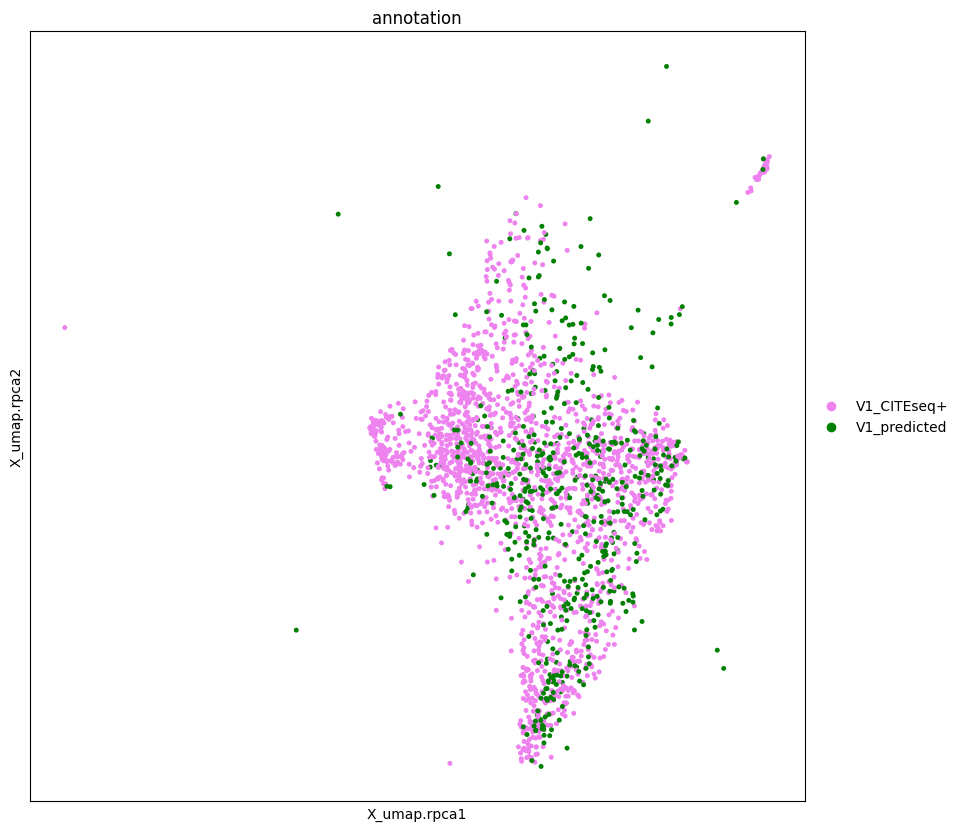

In [48]:
# plot the results
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged[merged.obs['v1'] == 'V1'], color='annotation', basis='X_umap.rpca', ax = ax)